In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
from matplotlib.colors import LogNorm
warnings.filterwarnings('ignore')

In [3]:
path = "/data/OWN/SF1test/AnH3/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars")

loading Dark matter..
loading Stars..
loading Gas..


In [4]:
myhalo.r_virial(600)

| r_200 = 224.4140625
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.330e+12 M_sun
| p_dm_200      =  8.558e+05 particles
| stellar mass  =  1.390e+11 M_sun
| p_st_200      =  4.925e+06 psrticles
| gas mass      =  1.084e+11 M_sun
| p_gs_200      =  1.951e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |16, 0, 0|
| D =| 0,14, 0|
|    | 0, 0, 3|


In [5]:
nucenter = nbe.real_center(myhalo.dm.pos3d, myhalo.dm.mass)
myhalo.center_shift(nucenter)
myhalo.redefine(4.5)

In [6]:
ok,rho_st,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)

In [7]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

# Direct Measurements
## $\rho(r)$


In [8]:
hsml = myhalo.gs.hsml.min()
# R array logarithmic Bining
r_p = np.logspace(np.log10(hsml),np.log10(2.5*myhalo.r200),60)
n_dm,r = np.histogram(myhalo.dm.r,bins=r_p)
vol = np.array([])
r1,r2 =r_p[:-1],r_p[1:]
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
profile = n_dm*myhalo.dm.mass[0]/vol
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.

rr = r

In [9]:
# extra estatistics from Cfalcon density
mean = np.array([])
std = np.array([])
n=np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myhalo.dm.r > r_p[i])&(myhalo.dm.r < r_p[i+1])&(myhalo.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(rho_dm[shell]))
    std = np.append(std,np.std(rho_dm[shell]))

In [10]:
def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator
chi2 = probfit.Chi2Regression(abg_profile, r, profile,std)

In [17]:
m = Minuit(chi2, 
         po=8.0, error_po=0.01,     limit_po=(7.,15.),
         r_s=4.3,    error_r_s=0.01,     limit_r_s=(2.,8.),
         al=1.,     error_al=0.001,    limit_al=(0.1,9.),
         be=3,  error_be=0.01,   limit_be=(0.01,3.5),
         ga=1,  error_ga=0.0001,   limit_ga=(0,4.65))
m.migrad();

FCN = 2.31546441147 
 TOTAL NCALL = 710 
 NCALLS = 710 
 
 
 EDM = 7.43565813049e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 7.57582 
 0.309337 
 0 
 0 
 7.0 
 15.0 
 
 
 
 
 2 
 r_s 
 5.43576 
 1.97467 
 0 
 0 
 2.0 
 8.0 
 
 
 
 
 3 
 al 
 7.95976 
 8.13543 
 0 
 0 
 0.1 
 9.0 
 
 
 
 
 4 
 be 
 2.34189 
 0.262989 
 0 
 0 
 0.01 
 3.5 
 
 
 
 
 5 
 ga 
 1.58106 
 0.0831638 
 0 
 0 
 0.0 
 4.65 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 7.576e+00 & 3.093e-01 & & & 7.000e+00 & 1.500e+01 & \\
\hline
2 & $r_{s}$ & 5.436e+00 & 1.975e+00 & & & 2.000e+00 & 8.000e+00 & \\
\hline
3 & al & 7.960e+00 & 8.135e+00 & & & 1.000e-01 & 9.000e+00 & \\
\hline
4 & be & 2.342e+00 & 2.630e-01 & & & 1.000e-02 & 3.500e+00 & \\
\hline
5 & ga & 1.581e+00 & 8.316e-02 & & & 0.000e+00 & 4.650e+00 & \\
\hline
\end{tabular}

$\langle rho \rangle(r) = \frac{1}{N} \sum_i^N \, \rho_i$
$\sigma^2(r) = \frac{1}{N-1} \sum_i^N \, (\rho_i - \langle rho
\rangle(r))^2$.


In [15]:
myhalo.gs.hsml.min()

0.19075024

<IPython.core.display.Javascript object>


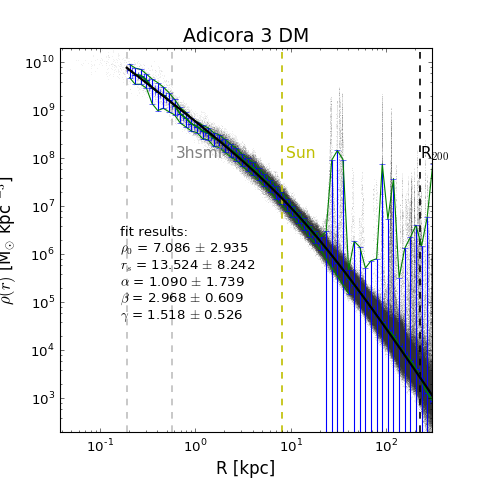

In [48]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([0.2*hsml,300])
ax.set_ylim([2e2,2e10])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_title("Adicora 3 DM",fontsize=17)
#horizontal lines
ax.axvline(x=hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=3*hsml,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhalo.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profile+std
mean_minu = profile-std

#  plot things
#ax.scatter(myhalo.dm.r,rho_dm,s=0.02,lw=0,alpha=0.6,c='#FF9100')
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')
ax.errorbar(r,profile,xerr=bin_size,yerr=std)
ax.scatter(myhalo.dm.r,rho_dm,s=0.2,lw=0,alpha=0.2,c='gray')

#plot means
ax.plot(r,profile,lw=1.5)
"""
ax.plot(r_p,abg_profile(r_p,m.values['po'] ,m.values['r_s'],m.values['al'],m.values['be'],m.values['ga']),
        "k",lw=2)

expected = abg_profile(r,m.values['po'] ,m.values['r_s'],m.values['al'],m.values['be'],m.values['ga'])
observed = profile
c = (observed- expected)**2 / std**2
print np.sum(c)/29
texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["po"],m.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["r_s"],m.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["al"],m.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["be"],m.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m.values["ga"],m.errors["ga"])+"\n"
"""


ax.plot(r_p,abg_profile(r_p,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],
                        m_SC.values['be'],m_SC.values['ga']),'k',linewidth=2, label='fit')

texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["po"],m_SC.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["r_s"],m_SC.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["al"],m_SC.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["be"],m_SC.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["ga"],m_SC.errors["ga"])+"\n"


fig.text(0.25,0.3,texto,fontsize=12)
ax.text(3*hsml*1.1,1e8,"3hsml",color='gray',fontsize=14)
ax.text(8*1.1,1e8,"Sun",color='y',fontsize=14)
ax.text(myhalo.r200*1.01,1e8,r"R$_{200}$",color='k',fontsize=14)



#  Sanity check

In [35]:
def chi2(po,r_s,al,be,ga):
    chi2_array =np.array([])
    expected = abg_profile(r,po,r_s,al,be,ga)
    observed = profile
    #c = ((observed)- expected)**2 / std**2
    c = ((observed)- expected)**2 / expected**2

    chi2_array = np.append(chi2_array,c)
    return np.nansum(chi2_array)

In [40]:
m_SC = Minuit(chi2, 
         po=8.0, error_po=0.01,     limit_po=(7.,11.),
         r_s=4.3,    error_r_s=0.01,     limit_r_s=(2.,14.),
         al=1.,     error_al=0.001,    limit_al=(0.1,14),
         be=3,  error_be=0.01,   limit_be=(0.01,3.5),
         ga=1,  error_ga=0.0001,   limit_ga=(0.5,10))
m_SC.migrad();

FCN = 0.839816213018 
 TOTAL NCALL = 447 
 NCALLS = 447 
 
 
 EDM = 0.000117606504014 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 7.08636 
 2.93469 
 0 
 0 
 7.0 
 11.0 
 
 
 
 
 2 
 r_s 
 13.5236 
 8.2419 
 0 
 0 
 2.0 
 14.0 
 
 
 
 
 3 
 al 
 1.09005 
 1.73882 
 0 
 0 
 0.1 
 14.0 
 
 
 
 
 4 
 be 
 2.96765 
 0.609376 
 0 
 0 
 0.01 
 3.5 
 
 
 
 
 5 
 ga 
 1.5176 
 0.525673 
 0 
 0 
 0.5 
 10.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 7.086e+00 & 2.935e+00 & & & 7.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 1.352e+01 & 8.242e+00 & & & 2.000e+00 & 1.400e+01 & \\
\hline
3 & al & 1.090e+00 & 1.739e+00 & & & 1.000e-01 & 1.400e+01 & \\
\hline
4 & be & 2.968e+00 & 6.094e-01 & & & 1.000e-02 & 3.500e+00 & \\
\hline
5 & ga & 1.518e+00 & 5.257e-01 & & & 5.000e-01 & 1.000e+01 & \\
\hline
\end{tabular}

In [41]:
Pcrit = myhalo.dm._p.rho_crit
Mdm = myhalo.dm.mass.min()
myradiuses = myhalo.dm.r[np.argsort(myhalo.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03

1.62222691537


In [42]:
print myhalo.gs.hsml.min()

0.19075


<IPython.core.display.Javascript object>


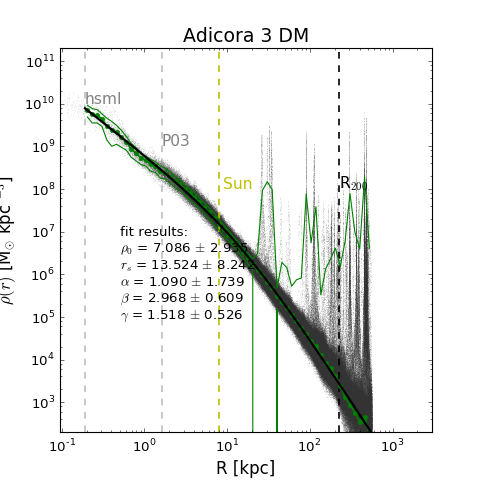

0.157017151607


In [45]:
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([hsml/2.,3000])
ax.set_ylim([2e2,2e11])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
ax.set_title("Adicora 3 DM",fontsize=17)
#horizontal lines
ax.axvline(x=R_P03,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=myhalo.gs.hsml.min(),c='gray',alpha=0.5,linestyle='--',lw=1.5)

ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhalo.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profile+std
mean_minu = profile-std
#  plot things
# density points
#ax.scatter(myhalo.dm.r,rho_dm,s=0.2,lw=0,alpha=0.6,c='#FF9100')
ax.scatter(myhalo.dm.r,rho_dm,s=0.2,lw=0,alpha=0.2,c='gray')
# mean plus sigma
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
# mean minus sigma
mean_minu[np.isnan(np.log10(mean_minu))] = 0
ax.plot(r,mean_minu,c='g')

# mean
ax.plot(r,profile,'g-o', lw=1.5,markeredgecolor='g',ms=4 )
# fit
ax.plot(r_p,abg_profile(r_p,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],
                        m_SC.values['be'],m_SC.values['ga']),'k',linewidth=2, label='fit')

texto = "fit results: \n"
texto += r"$\rho_0$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["po"],m_SC.errors["po"])+"\n"
texto += r"$r_s$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["r_s"],m_SC.errors["r_s"])+"\n"
texto += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["al"],m_SC.errors["al"])+"\n"
texto += r"$\beta$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["be"],m_SC.errors["be"])+"\n"
texto += r"$\gamma$ = {0:.3f} $\pm$ {1:.3f}".format(m_SC.values["ga"],m_SC.errors["ga"])+"\n"

fig.text(0.25,0.3,texto,fontsize=12)
ax.text(R_P03,1e9,"P03",color='gray',fontsize=14)
ax.text(myhalo.gs.hsml.min(),1e10,"hsml",color='gray',fontsize=14)

ax.text(8*1.1,1e8,"Sun",color='y',fontsize=14)
ax.text(myhalo.r200*1.01,1e8,r"R$_{200}$",color='k',fontsize=14)

expected = abg_profile(r,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],m_SC.values['be'],m_SC.values['ga'])
observed = profile
c = (observed- expected)**2 / std**2
print np.sum(c)/29

<IPython.core.display.Javascript object>


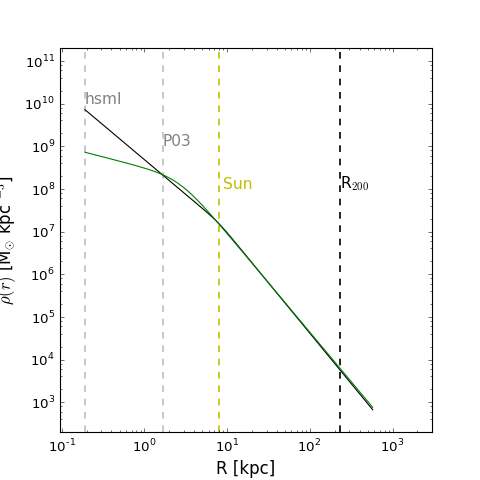

In [19]:
# 8.28592855973 2.66699759309 2.9897639672 2.31672476083 0.500000021633
fig, ax = plt.subplots(figsize=[6,6])
ax.set_xlim([hsml/2.,3000])
ax.set_ylim([2e2,2e11])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel(r'$\rho(r)$ [M$_{\odot}$ kpc $^{-3}$]',fontsize=15)
#horizontal lines
ax.axvline(x=R_P03,c='gray',alpha=0.5,linestyle='--',lw=1.5)
ax.axvline(x=myhalo.gs.hsml.min(),c='gray',alpha=0.5,linestyle='--',lw=1.5)

ax.axvline(x=8,c='y',linestyle='--',lw=1.5) #Sun
ax.axvline(x=myhalo.r200,c='k',linestyle='--',lw=1.5) #r200
#define sigma pluss and sigma minus lines
mean_plus = profile+std
mean_minu = profile-std
#  plot things
# density points
#ax.scatter(myhalo.dm.r,rho_dm,s=0.2,lw=0,alpha=0.6,c='#FF9100')
# mean plus sigma
#ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
#        c='g')
# mean minus sigma
#mean_minu[np.isnan(np.log10(mean_minu))] = 0
#ax.plot(r,mean_minu,c='g')
# fit
ax.plot(r_p,abg_profile(r_p,m_SC.values['po'] ,m_SC.values['r_s'],m_SC.values['al'],
                        m_SC.values['be'],m_SC.values['ga']),'k', label='fit ')
ax.plot(r_p,abg_profile(r_p,8.28592855973, 2.66699759309, 2.9897639672, 2.31672476083, 0.500000021633),'g', label='fit')
# mean
#ax.plot(r,profile,'g-o', lw=1.5,markeredgecolor='g',ms=4 )
ax.text(R_P03,1e9,"P03",color='gray',fontsize=14)
ax.text(myhalo.gs.hsml.min(),1e10,"hsml",color='gray',fontsize=14)

ax.text(8*1.1,1e8,"Sun",color='y',fontsize=14)
ax.text(myhalo.r200*1.01,1e8,r"R$_{200}$",color='k',fontsize=14)


In [19]:
print texto

fit results: 
$\rho_0$ = 7.575 $\pm$ 0.306
$r_s$ = 5.446 $\pm$ 1.948
$\alpha$ = 7.754 $\pm$ 5.013
$\beta$ = 2.343 $\pm$ 0.252
$\gamma$ = 1.581 $\pm$ 0.083



# Stars

In [28]:
stars_bins=70

print 10**1.3
xedges = np.logspace(-1,np.log10(10),stars_bins)
yedges = np.linspace(-1.,1.,stars_bins/2)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
sigma_st = np.zeros([len(yedges)-1,len(xedges)-1])

print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhalo.st.R >= xedges[i] )&(myhalo.st.R < xedges[i+1] )
        Zcon = (myhalo.st.pos3d[:,2] >= yedges[j])&(myhalo.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhalo.st.mass[np.where(Rcon&Zcon)])
        sigma_st[j][i] = np.std(rho_st[np.where(Rcon&Zcon)])
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(34, 69)


In [29]:

sigma_st[np.isinf(sigma_st)]

array([], dtype=float64)

<IPython.core.display.Javascript object>


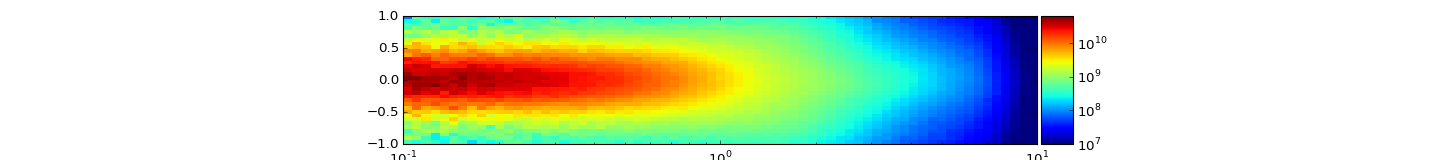

In [30]:
fig ,ax = plt.subplots(figsize=[18,2])

ax.set_xscale('log')
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')


In [31]:
def stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,d_0,Rd)+McMDisc(U[0],U[1],z_D,D_0,RD))



R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)

def chi2_st(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd,D_0,z_D,RD)
    observed = dens_hist
    #c = ((observed) - (expected))**2 / sigma_st
    c = (np.log10(observed) - np.log10(expected))**2 / np.log10(expected)**2

    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)# + diff**2)


def mass_check(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhalo.st.mass[np.where((myhalo.st.R<50.)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

In [33]:
m1=Minuit(chi2_st, 
         B_0=10.58, error_B_0=0.5,     limit_B_0=(10,10.8),
         r0=0.5,    error_r0=0.1,     limit_r0=(0.01,3.6),
         al=0.01,     error_al=0.1,    limit_al=(0,5.),
         r_cut=0.55,  error_r_cut=0.1,   limit_r_cut=(0.1,0.6),
         q=0.62,      error_q=0.1,     limit_q=(0,1.),
         d_0=9.6,    error_d_0=1,     limit_d_0=(9.,10.5),
         z_d=0.2,  error_z_d=0.2,  limit_z_d=(0.,0.5),
         Rd=0.5,     error_Rd=0.01,        limit_Rd=(0.1,1.0),
         D_0=9.4,    error_D_0=1,     limit_D_0=(9.,10.5),
         z_D=0.6,  error_z_D=0.02,  limit_z_D=(0.3,1.2),
         RD=2.3,     error_RD=0.01,        limit_RD=(1.2,4.))
#         print_level=0)
m1.migrad();

err = 0.1
upp = 1.1
low = 0.95
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         d_0=m1.values['d_0'], error_d_0=m1.values['d_0']*err, limit_d_0=(m1.values['d_0']*low,m1.values['d_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp),
         D_0=m1.values['D_0'], error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_D=m1.values['z_D'], error_z_D=m1.values['z_D']*err,  limit_z_D=(m1.values['z_D']*low,m1.values['z_D']*upp),
         RD=m1.values['RD'], error_RD=m1.values['RD']*err, limit_RD=(m1.values['RD']*low,m1.values['RD']*upp))
#         print_level=0)

m2.migrad();

FCN = 0.377321834655 
 TOTAL NCALL = 483 
 NCALLS = 483 
 
 
 EDM = 7.92833205723e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 10.5421 
 0.637539 
 0 
 0 
 10.0 
 10.8 
 
 
 
 
 2 
 r0 
 0.0100113 
 2.43397 
 0 
 0 
 0.01 
 3.6 
 
 
 
 
 3 
 al 
 0.000157826 
 3.54113 
 0 
 0 
 0.0 
 5.0 
 
 
 
 
 4 
 r_cut 
 0.599385 
 0.359191 
 0 
 0 
 0.1 
 0.6 
 
 
 
 
 5 
 q 
 0.543602 
 0.204985 
 0 
 0 
 0.0 
 1.0 
 
 
 
 
 6 
 d_0 
 9.6 
 1.04962 
 0 
 0 
 9.0 
 10.5 
 
 
 
 
 7 
 z_d 
 0.271266 
 0.335416 
 0 
 0 
 0.0 
 0.5 
 
 
 
 
 8 
 Rd 
 0.997369 
 0.895826 
 0 
 0 
 0.1 
 1.0 
 
 
 
 
 9 
 D_0 
 9.44006 
 0.20654 
 0 
 0 
 9.0 
 10.5 
 
 
 
 
 10 
 z_D 
 0.696755 
 0.340144 
 0 
 0 
 0.3 
 1.2 
 
 
 
 
 11 
 RD 
 1.84134 
 0.37073 
 0 
 0 
 1.2 
 4.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 1.054e+01 & 6.375e-01 & & & 1.000e+01 & 1.080e+01 & \\
\hline
2 & r0 & 1.001e-02 & 2.434e+00 & & & 1.000e-02 & 3.600e+00 & \\
\hline
3 & al & 1.578e-04 & 3.541e+00 & & & 0.000e+00 & 5.000e+00 & \\
\hline
4 & $r_{cut}$ & 5.994e-01 & 3.592e-01 & & & 1.000e-01 & 6.000e-01 & \\
\hline
5 & q & 5.436e-01 & 2.050e-01 & & & 0.000e+00 & 1.000e+00 & \\
\hline
6 & $d_{0}$ & 9.600e+00 & 1.050e+00 & & & 9.000e+00 & 1.050e+01 & \\
\hline
7 & $z_{d}$ & 2.713e-01 & 3.354e-01 & & & 0.000e+00 & 5.000e-01 & \\
\hline
8 & Rd & 9.974e-01 & 8.958e-01 & & & 1.000e-01 & 1.000e+00 & \\
\hline
9 & $D_{0}$ & 9.440e+00 & 2.065e-01 & & & 9.000e+00 & 1.050e+01 & \\
\hline
10 & $z_{D}$ & 6.968e-01 & 3.401e-01 & & & 3.000e-01 & 1.200e+00 & \\
\hline
11 & RD & 1.841e+00 & 3.707e-01 & & & 1.200e+00 & 4.000e+00 & \\
\hline
\end{tabular}

FCN = 4.71482053399e-07 
 TOTAL NCALL = 279 
 NCALLS = 279 
 
 
 EDM = 5.68580331671e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 10.5334 
 1.73319e-11 
 0 
 0 
 10.0149996582 
 11.5963153937 
 
 
 
 
 2 
 r0 
 0.00951254 
 3.24434e-12 
 0 
 0 
 0.00951075835016 
 0.011012457037 
 
 
 
 
 3 
 al 
 0.000173607 
 2.72437e-15 
 0 
 0 
 0.000149934387722 
 0.000173608238415 
 
 
 
 
 4 
 r_cut 
 0.595763 
 7.03254e-12 
 0 
 0 
 0.56941558066 
 0.659323303922 
 
 
 
 
 5 
 q 
 0.534924 
 1.60511e-11 
 0 
 0 
 0.516421437933 
 0.597961664976 
 
 
 
 
 6 
 d_0 
 9.58644 
 2.6696e-11 
 0 
 0 
 9.12 
 10.56 
 
 
 
 
 7 
 z_d 
 0.265248 
 1.0825e-11 
 0 
 0 
 0.257702564238 
 0.298392442802 
 
 
 
 
 8 
 Rd 
 0.98438 
 2.45523e-11 
 0 
 0 
 0.947500752915 
 1.09710613495 
 
 
 
 
 9 
 D_0 
 9.43761 
 5.35838e-12 
 0 
 0 
 8.96805619515 
 10.3840650681 
 
 
 
 
 10 
 z_D 
 0.692289 
 8.97499e-12 
 0 
 0 
 0.661916923543 
 0.766430121997 
 
 
 
 
 11 
 RD 
 1.83631 
 1.03703e-11 
 0 
 0 
 1.7492724158 
 2.02547332355 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 1.053e+01 & 1.733e-11 & & & 1.001e+01 & 1.160e+01 & \\
\hline
2 & r0 & 9.513e-03 & 3.244e-12 & & & 9.511e-03 & 1.101e-02 & \\
\hline
3 & al & 1.736e-04 & 2.724e-15 & & & 1.499e-04 & 1.736e-04 & \\
\hline
4 & $r_{cut}$ & 5.958e-01 & 7.033e-12 & & & 5.694e-01 & 6.593e-01 & \\
\hline
5 & q & 5.349e-01 & 1.605e-11 & & & 5.164e-01 & 5.980e-01 & \\
\hline
6 & $d_{0}$ & 9.586e+00 & 2.670e-11 & & & 9.120e+00 & 1.056e+01 & \\
\hline
7 & $z_{d}$ & 2.652e-01 & 1.082e-11 & & & 2.577e-01 & 2.984e-01 & \\
\hline
8 & Rd & 9.844e-01 & 2.455e-11 & & & 9.475e-01 & 1.097e+00 & \\
\hline
9 & $D_{0}$ & 9.438e+00 & 5.358e-12 & & & 8.968e+00 & 1.038e+01 & \\
\hline
10 & $z_{D}$ & 6.923e-01 & 8.975e-12 & & & 6.619e-01 & 7.664e-01 & \\
\hline
11 & RD & 1.836e+00 & 1.037e-11 & & & 1.749e+00 & 2.025e+00 & \\
\hline
\end{tabular}


# use minimize


In [34]:
#m1.minos()

In [35]:

def mass_integrated(edge):
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    #"""
    rho = 2. * np.pi * U[0] * stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                    m2.values['q'], m2.values['d_0'], m2.values['z_d'], m2.values['Rd'],
                                    m2.values['D_0'], m2.values['z_D'], m2.values['RD'])
    """
    rho = 2. * np.pi * U[0] * stars(U[0],U[1],m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
                                    m1.values['q'], m1.values['d_0'], m1.values['z_d'], m1.values['Rd'],
                                    m1.values['D_0'], m1.values['z_D'], m1.values['RD'])
    """
    def integrand(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
        return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                      m2.values['q'], m2.values['d_0'], m2.values['z_d'], m2.values['Rd'],m2.values['D_0'], m2.values['z_D'], m2.values['RD']))
    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
                                      m1.values['q'], m1.values['d_0'], m1.values['z_d'], m1.values['Rd'],m2.values['D_0'], m2.values['z_D'], m2.values['RD']))

    F = i[0] #firs level fit
    F2 = j[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhalo.st.mass[np.where((myhalo.st.R<edge)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
get_masses = np.vectorize(mass_integrated)
get_mass_data = np.vectorize(lambda u :np.sum(myhalo.st.mass[np.where((myhalo.st.R<u)&(np.abs(myhalo.st.pos3d[:,2])<u/10.))]))


In [36]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhalo.r200),20)
level1, level2 = get_masses(r_masses)
data_mass = get_mass_data(r_masses)

<IPython.core.display.Javascript object>


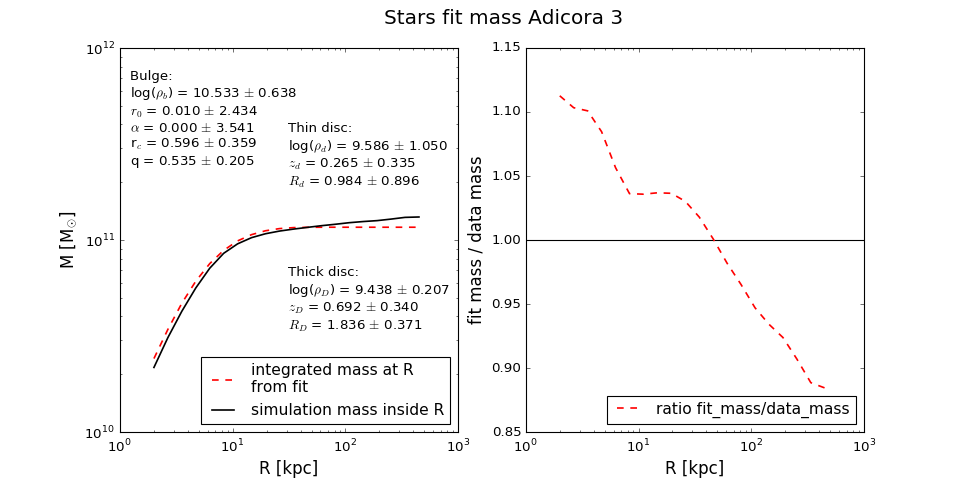

In [168]:
bulge = "Bulge: \n"
bulge += r"log($\rho _b$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["B_0"],m1.errors["B_0"])+"\n"
bulge += r"$r_0$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r0"],m1.errors["r0"])+"\n"
bulge += r"$\alpha$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["al"],m1.errors["al"])+"\n"
bulge += r"r$_c$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["r_cut"],m1.errors["r_cut"])+"\n"
bulge += r"q = {0:.3f} $\pm$ {1:.3f}".format(m2.values["q"],m1.errors["q"])+"\n"

thin_disc = "Thin disc: \n"
thin_disc += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["d_0"],m1.errors["d_0"])+"\n"
thin_disc += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_d"],m1.errors["z_d"])+"\n"
thin_disc += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["Rd"],m1.errors["Rd"])+"\n"

thik_disc = "Thick disc: \n"
thik_disc += r"log($\rho _D$) = {0:.3f} $\pm$ {1:.3f}".format(m2.values["D_0"],m1.errors["D_0"])+"\n"
thik_disc += r"$z_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["z_D"],m1.errors["z_D"])+"\n"
thik_disc += r"$R_D$ = {0:.3f} $\pm$ {1:.3f}".format(m2.values["RD"],m1.errors["RD"])+"\n"



fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Stars fit mass Adicora 3",fontsize=18)
fig.text(0.135,0.62,bulge,fontsize=12)
fig.text(0.3,0.58,thin_disc,fontsize=12)
fig.text(0.3,0.28,thik_disc,fontsize=12)

ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,level1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,level2,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,data_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,level2/data_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,level1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

<IPython.core.display.Javascript object>


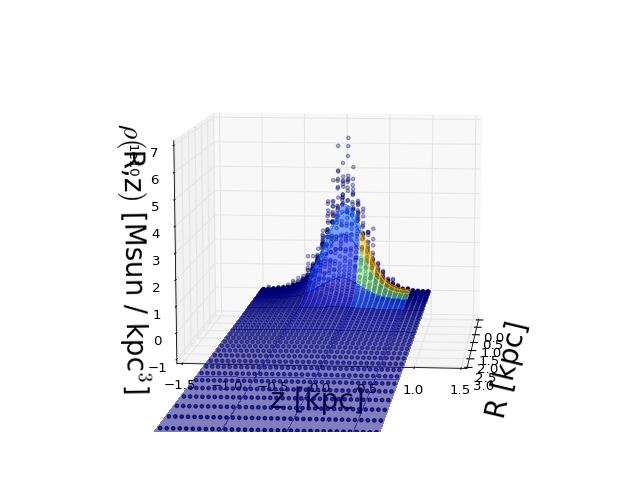

2346
2346
2346


In [173]:

bins = stars_bins
x = xedges#np.logspace(-1,np.log10(25),bins)
y = yedges#np.linspace(-6,6,bins/2.5)
U= np.meshgrid(x, y)


#Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])
Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
          m2.values['q'], 0, m2.values['z_d'], m2.values['Rd'],m2.values['D_0'],
          m2.values['z_D'], m2.values['RD'])

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
#ax.set_zscale('log')
ax.set_xlim([0,3])
R_test = (x[1:] + x[:-1])/2
Z_test = (y[1:] + y[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist.reshape(1,len(dens_hist)*len(dens_hist[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.set_xlabel("R [kpc]",fontsize=25)
my_col = cm.jet(Z/Z.max())
ax.set_ylabel("z [kpc]",fontsize=25)
ax.set_zlabel(r"$\rho($R,z$)$ [Msun / kpc$^3$]",fontsize=25)

ax.scatter(x_s, y_s,dens,marker='.',s=40)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm, facecolors = my_col,alpha=0.5,
                       linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>


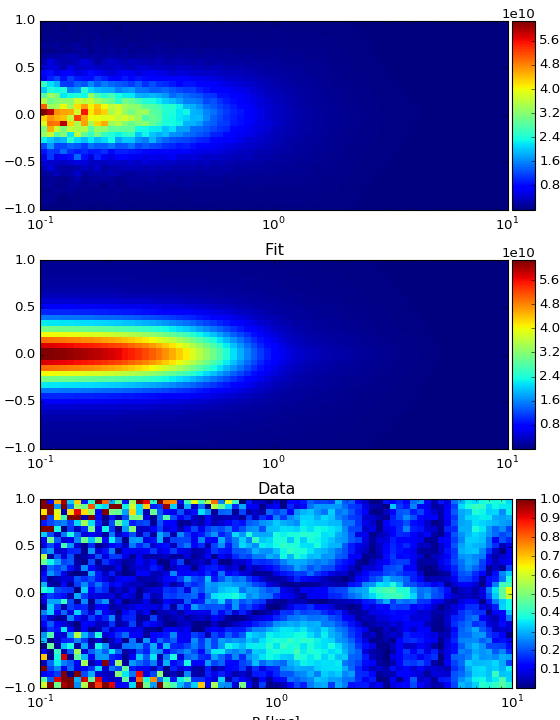

fit  : max = 3.848e+10, min = 2.791e+06
data : max = 6.263e+10, min = 4.246e+06


In [39]:
bins = stars_bins -1

x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x, y)


"""
Z = stars(U[0],U[1],10.4 ,.5 , 0 ,0.55,.62,
                    9.5, 0.2, 0.5,
                    9.3, 0.6, 2.3)
"""
"""
Z = stars(U[0],U[1],m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],m1.values['q'],
          m1.values['d_0'], m1.values['z_d'], m1.values['Rd'],
          m1.values['D_0'], m1.values['z_D'], m1.values['RD'])
"""
#"""
Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],m2.values['q'],
          m2.values['d_0'], m2.values['z_d'], m2.values['Rd'],
          m2.values['D_0'], m2.values['z_D'], m2.values['RD'])
#"""



fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9])


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')


fit = ax1.imshow(Z, interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]])#,norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

#ax.set_title("Data")

#real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
#                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())
print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist.max(),dens_hist.min())
ratio =  np.abs(Z-dens_hist)/dens_hist

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

<IPython.core.display.Javascript object>


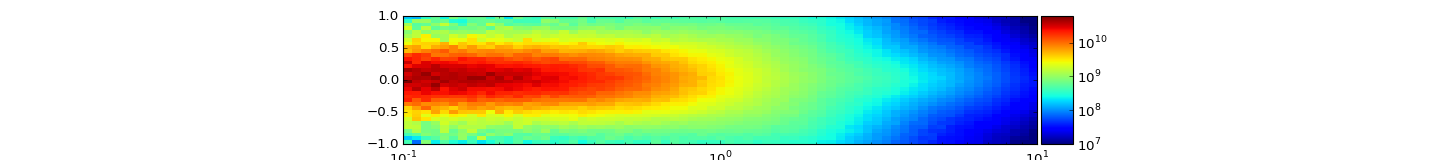

In [437]:
fig ,ax = plt.subplots(figsize=[18,2])

ax.set_xscale('log')
mapa =  (Z-dens_hist)**2 / sigma_st**2
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')


# Gas


In [40]:
log_hsml = np.log10(myhalo.gs.hsml.min())

In [102]:
gs_bins=40
edge = 20
zedge = edge/13.
x_gs = np.logspace(-0.5,np.log10(edge),gs_bins)
y_gs = np.linspace(-zedge,zedge,gs_bins)
dens_hist_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
sigma_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
for i in range(len(x_gs[:-1])):
    for j in range(len(y_gs[:-1])):
        Rcon = (myhalo.gs.R >= x_gs[i] )&(myhalo.gs.R < x_gs[i+1] )
        Zcon = (myhalo.gs.pos3d[:,2] >= y_gs[j])&(myhalo.gs.pos3d[:,2] < y_gs[j+1])
        mass = np.sum(myhalo.gs.mass[np.where(Rcon&Zcon)])
        sigma_gs[j][i] = np.std(myhalo.gs.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (y_gs[j+1]-y_gs[j]) * (x_gs[i+1]**2 - x_gs[i]**2)
        dens_hist_gs [j][i] = mass / volume 
    
    


<IPython.core.display.Javascript object>


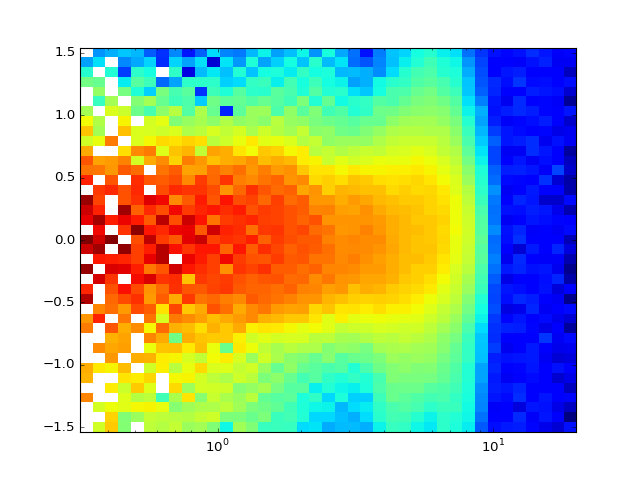

In [103]:
fig, ax = plt.subplots()
ax.set_xscale('log')
real =  plt.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])

#cbar = plt.colorbar(real)#,orientation='horizontal')

In [123]:
#def gas(R,z,D_0,z_d,Rm,Rd):        
#    return (10**D_0) * np.exp(- (Rm / R) - (R / Rd)) / (np.cosh(z /2./ z_d))**2


def gas(R,z,D_0,z_d,Rd):
        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2

R_array = (x_gs[1:] + x_gs[:-1])/2
Z_array = (y_gs[1:] + y_gs[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2_gas(D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = gas(R,Z,D_0,z_d,Rd)
    observed = dens_hist_gs
    c = ((observed) - (expected))**2 / sigma_gs**2
    c = ((observed) - (expected))**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)


def mass_check_gas(D_0,z_d,Rd):
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-edge/13.,edge/13.,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * gas(U[0],U[1],D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhalo.gs.mass[np.where((myhalo.gs.R<edge)&(np.abs(myhalo.gs.pos3d[:,2])<edge/10.))])
    N = len(myhalo.gs.mass[np.where((myhalo.gs.R<edge)&(np.abs(myhalo.gs.pos3d[:,2])<edge/10.))])
    diff = np.abs(np.log10(data_in) - np.log10(F))**2
    return  diff

In [162]:
mg1=Minuit(chi2_gas, 
           D_0=8.1,    error_D_0=0.1,     limit_D_0=(8.5,12.5),
           z_d=0.4,  error_z_d=0.1,  limit_z_d=(0.001,2),
           Rd=1.1,     error_Rd=0.1,        limit_Rd=(0.1,3))
mg1.migrad();

err = 0.01
upp = 1.2
low = 0.8
mg2=Minuit(mass_check_gas, 
         D_0=mg1.values['D_0'], error_D_0=mg1.values['D_0']*err, limit_D_0=(mg1.values['D_0']*low,mg1.values['D_0']*upp),
         z_d=mg1.values['z_d'], error_z_d=mg1.values['z_d']*err,  limit_z_d=(mg1.values['z_d']*low,mg1.values['z_d']*upp),
         Rd=mg1.values['Rd'], error_Rd=mg1.values['Rd']*err, limit_Rd=(mg1.values['Rd']*low,mg1.values['Rd']*upp))

mg2.migrad();

FCN = 6.04465133874e+19 
 TOTAL NCALL = 12 
 NCALLS = 12 
 
 
 EDM = 0.0 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 8.5 
 2.84213 
 0 
 0 
 8.5 
 12.5 
 
 
 
 
 2 
 z_d 
 0.4 
 1.14068 
 0 
 0 
 0.001 
 2.0 
 
 
 
 
 3 
 Rd 
 1.1 
 1.94086 
 0 
 0 
 0.1 
 3.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 8.500e+00 & 2.842e+00 & & & 8.500e+00 & 1.250e+01 & \\
\hline
2 & $z_{d}$ & 4.000e-01 & 1.141e+00 & & & 1.000e-03 & 2.000e+00 & \\
\hline
3 & Rd & 1.100e+00 & 1.941e+00 & & & 1.000e-01 & 3.000e+00 & \\
\hline
\end{tabular}

FCN = 5.32010801016e-08 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 1.38348249245e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 D_0 
 9.07717 
 2.557 
 0 
 0 
 6.80000305176 
 10.2000045776 
 
 
 
 
 2 
 z_d 
 0.479583 
 0.156812 
 0 
 0 
 0.32 
 0.48 
 
 
 
 
 3 
 Rd 
 1.31999 
 0.43037 
 0 
 0 
 0.88 
 1.32 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $D_{0}$ & 9.077e+00 & 2.557e+00 & & & 6.800e+00 & 1.020e+01 & \\
\hline
2 & $z_{d}$ & 4.796e-01 & 1.568e-01 & & & 3.200e-01 & 4.800e-01 & \\
\hline
3 & Rd & 1.320e+00 & 4.304e-01 & & & 8.800e-01 & 1.320e+00 & \\
\hline
\end{tabular}

In [163]:

def mass_integrated_gas(edge):
    """
    integraties the amount of mass obtained by the gas fit
     gas(R,z,D_0,z_d,Rd)
    """
    bins = 101
    zedge = edge/10.
    xe = np.linspace(0,edge,bins)
    ye = np.linspace(-zedge,zedge,bins)
    R_test = (xe[1:] + xe[:-1])/2
    Z_test = (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * U[0] * gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd'])

    def integrand(R,z,D_0,z_d,Rd):
        return 2. * np.pi * R * gas(R,z,D_0,z_d,Rd)

    j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg1.values['D_0'], mg1.values['z_d'], mg1.values['Rd']))

    i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd']))
    
    F = j[0] #firs level fit
    F2 = i[0] # second level fit
    return F , F2
#print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
#print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
#print "data = ",np.sum(myhalo.st.mass[np.where((myhalo.st.R<edge)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
get_masses_gs = np.vectorize(mass_integrated_gas)
get_mass_data_gs = np.vectorize(lambda u :np.sum(myhalo.gs.mass[np.where((myhalo.gs.R<u)&(np.abs(myhalo.gs.pos3d[:,2])<u/10.))]))


In [164]:
r_masses = np.logspace(np.log10(2),np.log10(2*myhalo.r200),20)
glevel1, glevel2 = get_masses_gs(r_masses)
gdata_mass = get_mass_data_gs(r_masses)

<IPython.core.display.Javascript object>


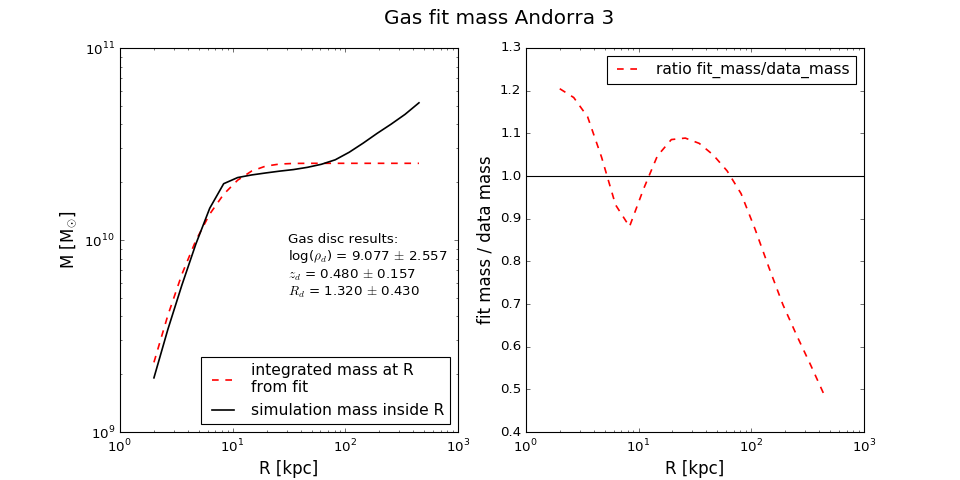

In [175]:
texto = "Gas disc results: \n"
texto += r"log($\rho _d$) = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["D_0"],mg2.errors["D_0"])+"\n"
texto += r"$z_d$ = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["z_d"],mg2.errors["z_d"])+"\n"
texto += r"$R_d$ = {0:.3f} $\pm$ {1:.3f}".format(mg2.values["Rd"],mg2.errors["Rd"])+"\n"

fig, ax = plt.subplots(1,2,figsize=[12,6])
fig.text(0.4,0.95,"Gas fit mass Andorra 3",fontsize=18)
fig.text(0.3,0.35,texto,fontsize=12)
ax[0].set_xlabel("R [kpc]",fontsize=15)
ax[1].set_xlabel("R [kpc]",fontsize=15)
ax[0].set_ylabel(r"M [M$_{\odot}$]",fontsize=15)
ax[1].set_ylabel(r"fit mass / data mass",fontsize=15)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_ylim([0.85,1.15])
#ax[0].plot(r_masses,glevel1,'b--')
ax[1].axhline(y=1,c='k')
ax[0].plot(r_masses,glevel2,'r--',lw=1.5,label="integrated mass at R\nfrom fit")
ax[0].plot(r_masses,gdata_mass,'k',lw=1.5,label="simulation mass inside R")
ax[1].plot(r_masses,glevel2/gdata_mass,'r--',lw=1.5,label="ratio fit_mass/data_mass")
#ax[1].plot(r_masses,glevel1/data_mass,'b--')
legend = ax[0].legend(loc='lower right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
legend = ax[1].legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/Mochima2/gasfit_Mochima2.pdf",dpi=300)

<IPython.core.display.Javascript object>


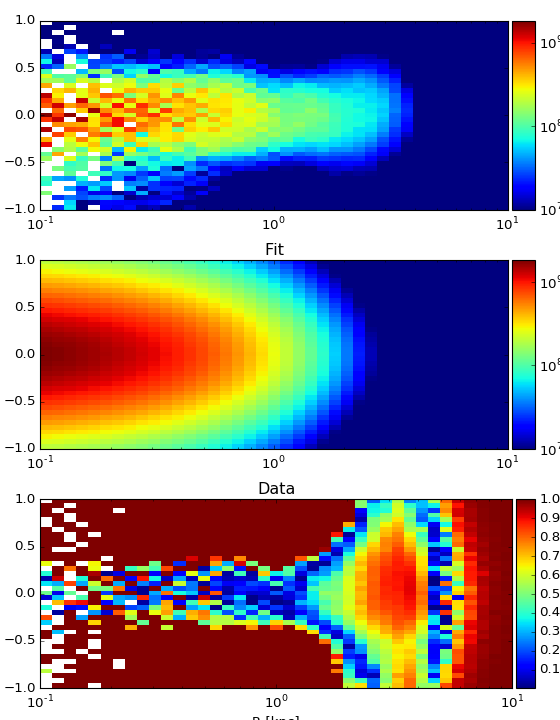

fit  : max = 9.400e+08, min = 4.692e+01
data : max = 1.823e+09, min = 4.246e+06


In [157]:
bins = gs_bins -1


edge = 20
zedge = edge/13.
x_gs = np.logspace(-0.5,np.log10(edge),bins)
y_gs = np.linspace(-zedge,zedge,bins)


x = np.logspace(-1,np.log10(10),bins)
y = np.linspace(-1,1,bins/2)

#x = np.logspace(-1,np.log10(25),bins)
#y = np.linspace(-6,6,(bins/2.5))
U= np.meshgrid(x_gs, y_gs)


"""
Z = gas(U[0],U[1],9.3, 0.2 , 1.2)
"""
#"""
Z = gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'] , mg2.values['Rd'])
#"""



fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[7,9])


plt.tight_layout(h_pad=2)
ax.set_xscale('log')
real = ax.imshow(dens_hist_gs, interpolation='nearest', origin='low',aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')


fit = ax1.imshow(Z, interpolation='nearest', origin='low',aspect='auto',
                  extent=[x[0], x[-1], y[0], y[-1]],norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

#ax.set_title("Data")

#real = ax.imshow(dens_hist, interpolation='nearest', origin='low',aspect='auto',
#                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print "fit  : max = {0:.3e}, min = {1:.3e}".format(Z.max(),Z.min())
print "data : max = {0:.3e}, min = {1:.3e}".format(dens_hist_gs.max(),dens_hist.min())
ratio =  np.abs(Z-dens_hist_gs)/dens_hist_gs

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.set_xscale('log')

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,norm=LogNorm(vmax=1e0))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')